# Introduction

In this Notebook, I apply the cnnclassification architecture from this paper: https://arxiv.org/pdf/1611.06455.pdf to the infant cry classification problem. Some of the Code is adapted from official TensorFlow ressources, which are linked below.
The other notebooks, as well as the thesis can be found at https://github.com/fridowicke/infant_cries

# Imports

In [ ]:
import tensorflow as tf
import numpy as np
from google.colab import drive
import json

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

# Loading the Data

## Mount the Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Save / Load Processed Data

In [ ]:
#Helper function
def load(filename):
    with open(filename) as data:
        x = json.load(data)
    return np.array(x)

#We use json to save the spectrograms and f0s of the produced data in order to avoid computing them every time we use the notebook.
#Helper functions
def save(data, filename):
    if type(data) is np.ndarray:
      data = data.tolist()
    with open(filename, 'w') as f:
        json.dump(data, f, ensure_ascii=False)

In [ ]:
#Load the f0s

fs_train    = load("/content/drive/My Drive/infant_cries/data_js_final/fs_train.json")
fs_dev_ger  = load("/content/drive/My Drive/infant_cries/data_js_final/fs_dev_ger.json")
fs_dev_jap  = load("/content/drive/My Drive/infant_cries/data_js_final/fs_dev_jap.json")
fs_test_ger  = load("/content/drive/My Drive/infant_cries/data_js_final/fs_test_ger.json")
fs_test_jap  = load("/content/drive/My Drive/infant_cries/data_js_final/fs_test_jap.json")
fs_eval     = (load("/content/drive/My Drive/infant_cries/data_js_final/fs_eval.json"))
y_train      = load("/content/drive/My Drive/infant_cries/data_js_final/y_train.json")

## Create Datasets

In [ ]:
#Reshape the f_s
input_shape = fs_train.shape[1:]
fs_train = fs_train.reshape((fs_train.shape[0], 1, fs_train.shape[1],))
fs_dev_ger = fs_dev_ger.reshape((fs_dev_ger.shape[0], 1, fs_dev_ger.shape[1]))
fs_dev_jap = fs_dev_jap.reshape((fs_dev_jap.shape[0], 1, fs_dev_jap.shape[1]))
fs_test_ger = fs_test_ger.reshape((fs_test_ger.shape[0], 1, fs_test_ger.shape[1]))
fs_test_jap = fs_test_jap.reshape((fs_test_jap.shape[0], 1, fs_test_jap.shape[1]))
fs_eval = fs_eval.reshape((fs_eval.shape[0], 1, fs_eval.shape[1]))



#Compute the number of samples
n_dev_ger = fs_dev_ger.shape[0]
n_dev_jap = fs_dev_jap.shape[0]
n_test_ger = fs_test_ger.shape[0]
n_test_jap = fs_test_jap.shape[0]
n_eval = fs_eval.shape[0]

#Create y_s for dev, test and eval
y_dev_ger = np.zeros(n_dev_ger)
y_dev_jap = np.ones(n_dev_jap)
y_test_ger = np.zeros(n_test_ger)
y_test_jap = np.ones(n_test_jap)
y_eval    = np.zeros(n_eval)

# CNN

## Function to build the model

In [ ]:
#Source: https://keras.io/examples/timeseries/timeseries_classification_from_scratch/
#Paper https://arxiv.org/pdf/1611.06455.pdf
num_classes=2

def build_cnn(input_shape=fs_train.shape[1:]):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

## Finding the right number of epochs

In [ ]:
cnn = build_cnn()
cnn.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
accs_dev = np.zeros(100)
for idx1 in range(10):
  for idx in range(100):
    print(idx)
    cnn.fit(fs_train, y_train, epochs = 1, verbose=0)
    _, acc_dev_ger = cnn.evaluate(fs_dev_ger, y_dev_ger, verbose=0)
    _, acc_dev_jap = cnn.evaluate(fs_dev_jap, y_dev_jap, verbose=0)
    acc_dev  = (acc_dev_ger+acc_dev_jap)/2
    accs_dev[idx] = accs_dev[idx]+acc_dev

accs_dev = accs_dev/10

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(100), accs_dev, color='orange', label='Accuracy on the Development Set')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuarcy')
plt.hlines(np.max(accs_dev), 0, np.argmax(accs_dev), colors='grey', linestyles='dashed')
plt.vlines(np.argmax(accs_dev), np.min(accs_dev), np.max(accs_dev), colors='grey', linestyles='dashed')
plt.legend(loc='lower right')
plt.show()

In [ ]:
np.argmax(accs_dev)

70

## Testing the optimal values for 100 runs

In [ ]:
accs_dev_1DCnn  = []
accs_test_1DCnn = []
fscore_eval_1DCnn   = []

for idx in range(100):
  print(idx)
  cnn = build_cnn()
  cnn.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  cnn.fit(fs_train, y_train, epochs = 70, verbose=0)
  _, acc_dev_ger = cnn.evaluate(fs_dev_ger, y_dev_ger, verbose=0)
  _, acc_dev_jap = cnn.evaluate(fs_dev_jap, y_dev_jap, verbose=0)
  _, acc_test_ger = cnn.evaluate(fs_test_ger, y_test_ger, verbose=0)
  _, acc_test_jap = cnn.evaluate(fs_test_jap, y_test_jap, verbose=0)
  _, acc_eval = cnn.evaluate(fs_eval, y_eval, verbose=0)
  acc_dev  = (acc_dev_ger+acc_dev_jap)/2
  acc_test = (acc_test_ger+acc_test_jap)/2
  accs_dev_1DCnn.append(acc_dev)
  accs_test_1DCnn.append(acc_test)
  fscore_eval_1DCnn.append(2*(acc_eval)/(1+acc_eval))

save(accs_dev_1DCnn,"/content/drive/My Drive/infant_cries/data_js_final/accs_dev_1DCnn.json")
save(accs_test_1DCnn,"/content/drive/My Drive/infant_cries/data_js_final/accs_test_1DCnn.json")
save(fscore_eval_1DCnn,"/content/drive/My Drive/infant_cries/data_js_final/fscore_eval_1DCnn.json")

In [ ]:
accs_dev_1DCnn  = load("/content/drive/My Drive/infant_cries/data_js_final/accs_dev_1DCnn.json")
accs_test_1DCnn = load ("/content/drive/My Drive/infant_cries/data_js_final/accs_test_1DCnn.json")
fscore_eval_1DCnn   = load("/content/drive/My Drive/infant_cries/data_js_final/fscore_eval_1DCnn.json")

Mean:0.49692309081554414, Min:0.42307692766189575, Max:0.5714285969734192
50th percentile. 0.49450550973415375


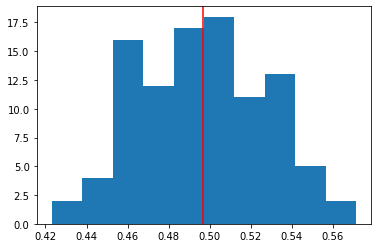

In [ ]:
print(f"Mean:{np.mean(accs_dev_1DCnn)}, Min:{np.min(accs_dev_1DCnn)}, Max:{np.max(accs_dev_1DCnn)}")
print(f"50th percentile. {np.percentile(accs_dev_1DCnn, 50)}")
plt.hist(accs_dev_1DCnn)
plt.axvline(np.mean(accs_dev_1DCnn), color='red')
plt.show()

Mean:0.4792592588067055, Min:0.37654320895671844, Max:0.5555555522441864


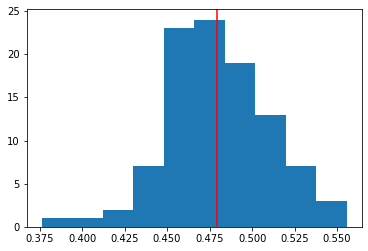

In [ ]:
print(f"Mean:{np.mean(accs_test_1DCnn)}, Min:{np.min(accs_test_1DCnn)}, Max:{np.max(accs_test_1DCnn)}")
plt.hist(accs_test_1DCnn)
plt.axvline(np.mean(accs_test_1DCnn), color='red')
plt.show()

Mean:0.6210246988186237, Min:0.5072463616600458, Max:0.728395064535564


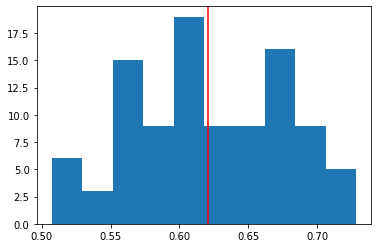

In [ ]:
print(f"Mean:{np.mean(fscore_eval_1DCnn)}, Min:{np.min(fscore_eval_1DCnn)}, Max:{np.max(fscore_eval_1DCnn)}")
plt.hist(fscore_eval_1DCnn)
plt.axvline(np.mean(fscore_eval_1DCnn), color='red')
plt.show()